<a href="https://colab.research.google.com/github/MarcelLopes7/Machine-Learning---Analytics/blob/main/MVP_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Machine Learning & Analytics
## Autor: Marcel Antonio Lopes Pereira

## Introdução

Esse MVP consiste na construção de um modelo de machine learning a partir de um dataset com dados de usuários de uma academia de exercícios físicos (Gym Members Exercise Dataset). Para compreensão do dataset em questão, os respectivos atributos são listados a seguir:

**Idade**: Idade do usuário da academia.

**Gênero**: Gênero do usuário da academia (Masculino ou Feminino).

**Peso (kg)**: Peso do usuário em quilogramas.

**Altura (m)**: Altura do usuário em metros.

**BPM Máx**: Frequência cardíaca máxima (batimentos por minuto) durante as sessões de treino.

**BPM Médio**: Frequência cardíaca média durante as sessões de treino.

**BPM Repouso**: Frequência cardíaca em repouso antes do treino.

**Duração da Sessão (horas)**: Duração de cada sessão de treino em horas.

**Calorias Queimadas**: Total de calorias queimadas durante cada sessão.

**Tipo de Treino**: Tipo de treino realizado (por exemplo, Cardio, Força, Yoga, HIIT).

**Percentual de Gordura**: Percentual de gordura corporal do usuário.

**Consumo de Água (litros)**: Consumo diário de água durante os treinos.

**Frequência de Treino (dias/semana)**: Número de sessões de treino por semana.

**Nível de Experiência**: Nível de experiência, de iniciante (1) a especialista (3).

**IMC**: Índice de Massa Corporal, calculado a partir da altura e do peso.

A partir da descrição dos atributos, é possível identificar várias ideias de problemas para ser solucinados. Foi escolhido um problema que consiste na predição do número de calorias queimadas por um usuário. Como o resultado dessa predição é um valor contínuo, esse é um problema de regressão, sendo então de aprendizado supervisionado. Inicialmente, serão explorados esses dados para entender suas distruibuições e correlações. A partir disso, será descrito o procedimento de tratamento e preparação dos mesmos para construção do modelo. Todo o processo de construção do modelo será detalhado, com suas definições e decisões tomadas.

## Importação das bibliotecas

Com os atributos definidos, o código do programa inicia com a importação das bibliotecas python que serão utilizadas nesse projeto. A seguir, são definidas algumas funções que serão utilizadas ao longo do código.

In [32]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import missingno as ms # para tratamento de missings
import math

## Importação das bibliotecas do scikitlearn para construção do modelo
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer

Essa biblioteca inclui um recurso para tradução de idiomas.

In [2]:
!pip install googletrans==4.0.0-rc1
from googletrans import Translator

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=0ec5106cde24e211c0a221f925da0ac4a9c0b5513ffaec96f22fa7ca1f67ea52
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Suc

## Funções utilizadas no programa

São definidas a seguir as funções utilizadas no código do programa para realizar algumas tarefas necessárias no projeto. A primeira delas é a função que realização normalização das colunas do dataset, removendo espaço, quebras de linha e caracteres especiais. Após definida essa função, são definidas funções para realizar a tradução do nome das colunas do inglês para o português.

In [33]:
# Função para normalizar o nome das colunas
# (remover espaços, quebras de linha e caracteres especiais)
def normalizar_coluna(coluna):
    # Remover quebras de linha, espaços extras e
    # caracteres especiais como hifens
    return re.sub(r'[\s\n\-_]+', ' ', coluna).strip().lower()

# Função para renomear as colunas e identificar as
# que não foram traduzidas
def traduzir_colunas(df, colunas_traduzidas):
    colunas_nao_traduzidas = []

    def traduzir_nome_coluna(coluna):
        nome_normalizado = normalizar_coluna(coluna)
        if nome_normalizado in colunas_traduzidas:
            return colunas_traduzidas[nome_normalizado]
        else:
            colunas_nao_traduzidas.append(coluna)  #
            # Adicionar colunas não traduzidas à lista
            return coluna  # Retorna o nome original se não for encontrado

    # Renomear as colunas
    df_traduzido = df.rename(columns=traduzir_nome_coluna)

    if colunas_nao_traduzidas:
        print("Colunas que não foram traduzidas:",
              colunas_nao_traduzidas)
    else:
        print("Todas as colunas foram traduzidas com sucesso.")

    return df_traduzido

Essa função realiza a tradução das palavras numa coluna específica selecionada a partir do dataframe.

In [34]:
# Inicializar o tradutor
translator = Translator()

# Função para traduzir colunas usando Google Translator
def traduzir_coluna(df, colunas):
    for coluna in colunas: # Iterate through the list of columns
        # Verifica se a coluna existe
        if coluna in df.columns:
            # Traduz cada valor da coluna
            df[coluna] = df[coluna].apply(
                lambda valor: translator.translate(x, dest='pt').text )
    return df  # Return the modified dataframe

Essa função é definida para remover colunas somente com variáveis do tipo string, caso seja necessário utilizar o dataset para realizar análises extritamente númericas, como na criação de uma matriz de correlação.

In [35]:
# Função para remover colunas object
def remover_colunas_object(df):

    # Selecionar apenas colunas que não são do tipo 'object'
    df_numerico = df.select_dtypes(exclude=['object'])

    return df_numerico

Função para construir bloxplots de todas as colunas numéricas em subplots organizados.

In [36]:
def boxplots(df_numerico, num_boxplots_por_linha=2,
             figsize=(12, 6), cor_paleta='viridis'):
    """
    Função para criar boxplots de todas as colunas numéricas em
    subplots organizados.

    Parâmetros:
    - df_numerico: DataFrame contendo apenas colunas numéricas.
    - num_boxplots_por_linha: Número de boxplots por linha
      (padrão é 2).
    - figsize: Tamanho base da figura (padrão é (12, 6)).
    - cor_paleta: Paleta de cores para os boxplots (padrão é
      'viridis').
    """
    # Número de colunas no dataframe
    num_colunas = df_numerico.shape[1]

    # Definir o número de linhas necessárias
    num_linhas = math.ceil(num_colunas / num_boxplots_por_linha)

    # Ajustar o tamanho da figura
    fig, axes = plt.subplots(
        nrows=num_linhas, ncols=num_boxplots_por_linha,
        figsize=(figsize[0], num_linhas * figsize[1])
    )

    # Flatten o array de eixos para simplificar a iteração
    axes = axes.flatten()

    # Definindo o estilo do Seaborn
    sns.set_theme(style="whitegrid")

    # Iterar sobre cada coluna do dataframe e criar um boxplot
    for i, col in enumerate(df_numerico.columns):
        sns.boxplot(x=df_numerico[col], ax=axes[i], palette=cor_paleta)
        axes[i].set_title(f'Boxplot da coluna: {col}', fontsize=12)
        axes[i].set_xlabel('')  # Remover o rótulo do eixo x
        axes[i].set_ylabel('Valores', fontsize=10)
        axes[i].grid(True)  # Adiciona grid para melhor visualização

    # Remover eixos não usados, se houver
    if num_colunas % num_boxplots_por_linha != 0:
        for j in range(num_colunas, len(axes)):
            fig.delaxes(axes[j])

    # Ajustar o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

Essa função realiza a seleção dos melhores atributos para treinamento do modelo

In [37]:
# Função para criar e rodar pipelines apenas com seleção de features
def run_feature_selection_comparison(X_train, y_train, model, k_values=range(5, 20), cv=10):
    """Compara um modelo com diferentes valores de k para seleção de features."""
    results = {}
    selected_features_per_k = {}

    print(f"\nModelo: {model.__class__.__name__}")

    # Testar diferentes valores de k
    for k in k_values:
        # Seleção de features separada para registrar os atributos selecionados
        selector = SelectKBest(score_func=f_regression, k=k)
        selector.fit(X_train, y_train)
        selected_features = X_train.columns[selector.get_support()]

        # Construir a pipeline
        steps = [('feature_selection', selector),
                 ('model', model)]
        pipeline = Pipeline(steps)

        # Validação cruzada
        scores = cross_val_score(
            pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
        )

        # Armazenar os resultados
        results[k] = {
            'MSE Médio': -np.mean(scores),
            'MSE Desvio': np.std(scores)
        }
        selected_features_per_k[k] = list(selected_features)

        print(f"k={k} -> MSE Médio: {-np.mean(scores):.4f}, "
              f"Desvio: {np.std(scores):.4f}")
        print(f"Atributos Selecionados: {', '.join(selected_features)}")

    # Determinar o k com menor erro
    best_k = min(results, key=lambda k: results[k]['MSE Médio'])
    best_features = selected_features_per_k[best_k]
    print(f"\nMelhor k: {best_k}")
    print(f"Atributos Selecionados para k={best_k}: {', '.join(best_features)}")

    return results, best_k, best_features

Essa função constrói uma pipeline e avalia o desempenho de diversos modelos de regressão a partir de uma base de treino especificada e de atributos selecionados, utilizando validação cruzada no processo

In [8]:
# Função para avaliar modelos com pipelines na base de treino
def evaluate_models_on_training(X_train, y_train, models, scalers, selected_features, cv=10):
    """Avalia modelos de regressão com diferentes escalonadores usando validação cruzada."""
    results = {}

    for scaler_name, scaler in scalers.items():
        print(f"\nCenário: {scaler_name}")
        scenario_results = {}

        # Filtrar os dados apenas com as features selecionadas
        X_train_selected = X_train[selected_features]

        # Escalonar dados, se necessário
        if scaler is not None:
            scaler.fit(X_train_selected)
            X_train_selected = scaler.transform(X_train_selected)

        # Testar cada modelo
        for model_name, model in models.items():
            print(f"\nModelo: {model_name}")

            # Construir a pipeline
            pipeline = Pipeline([('model', model)])

            # Validação cruzada
            scores = cross_val_score(
                pipeline, X_train_selected, y_train, cv=cv,
                scoring='neg_mean_squared_error', n_jobs=-1
            )

            # Armazenar os resultados
            scenario_results[model_name] = {
                'MSE CV': -np.mean(scores),
                'MSE Desvio': np.std(scores)
            }

            print(f"MSE CV: {-np.mean(scores):.4f}, "
                  f"Desvio: {np.std(scores):.4f}")

        results[scaler_name] = scenario_results

    return results

In [38]:
def evaluate_models_on_training(X_train, y_train, models, scalers, selected_features, cv=10):
    """
    Avalia modelos de regressão com diferentes escalonadores usando validação cruzada.

    Parâmetros:
        - X_train: DataFrame com os atributos de treino.
        - y_train: Série ou array com o alvo de treino.
        - models: Dicionário de modelos de regressão (nome -> instância).
        - scalers: Dicionário de escalonadores (nome -> instância ou None).
        - selected_features: Lista com os nomes das features selecionadas.
        - cv: Número de folds para a validação cruzada.

    Retorna:
        - results_df: DataFrame com a média e desvio padrão dos resultados.
        - all_cv_results: DataFrame com todos os resultados de validação cruzada (para boxplots).
    """
    results = []
    all_cv_results = []

    for scaler_name, scaler in scalers.items():
        print(f"\nCenário: {scaler_name}")

        # Filtrar os dados apenas com as features selecionadas
        X_train_selected = X_train[selected_features]

        # Escalonar dados, se necessário
        if scaler is not None:
            scaler.fit(X_train_selected)
            X_train_selected = scaler.transform(X_train_selected)

        # Testar cada modelo
        for model_name, model in models.items():
            print(f"\nModelo: {model_name}")

            # Construir a pipeline
            pipeline = Pipeline([('model', model)])

            # Validação cruzada
            scores = cross_val_score(
                pipeline, X_train_selected, y_train, cv=cv,
                scoring='neg_mean_squared_error', n_jobs=-1
            )

            # Armazenar os resultados
            mse_cv = -np.mean(scores)
            mse_std = np.std(scores)
            results.append({
                'Cenário': scaler_name,
                'Modelo': model_name,
                'MSE CV': mse_cv,
                'Desvio': mse_std
            })

            # Registrar todos os resultados individuais de validação cruzada
            for fold_score in -scores:  # Transformar os valores para MSE positivo
                all_cv_results.append({
                    'Cenário': scaler_name,
                    'Modelo': model_name,
                    'MSE': fold_score
                })

            print(f"MSE CV: {mse_cv:.4f}, Desvio: {mse_std:.4f}")

    # Consolidar resultados em DataFrames
    results_df = pd.DataFrame(results)
    all_cv_results_df = pd.DataFrame(all_cv_results)

    return results_df, all_cv_results_df

## Análise Exploratória e Preparação dos Dados



O dataset é importado para o notebook e convertido em dataframe. Em seguida, são exibidas as primeiras linhas do dataframe.

In [39]:
# URL de importação do dataset
url = (
    "https://raw.githubusercontent.com/MarcelLopes7/"
    "Machine-Learning---Analytics/refs/heads/main/"
    "gym_members_exercise_tracking.csv"
)

# Leitura do arquivo
dataframe = pd.read_csv(url)

# Visualização de todas as colunas do dataframe
pd.set_option(
    'display.max_columns', None
)

In [40]:
# Exibição das primeiras linhas do dataset
dataframe.head(10)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
5,56,Female,58.0,1.68,168,156,74,1.59,1116.0,HIIT,15.5,2.7,5,3,20.55
6,36,Male,70.3,1.72,174,169,73,1.49,1385.0,Cardio,21.3,2.3,3,2,23.76
7,40,Female,69.7,1.51,189,141,64,1.27,895.0,Cardio,30.6,1.9,3,2,30.57
8,28,Male,121.7,1.94,185,127,52,1.03,719.0,Strength,28.9,2.6,4,2,32.34
9,28,Male,101.8,1.84,169,136,64,1.08,808.0,Cardio,29.7,2.7,3,1,30.07


Para facilitar a visualização das informações no mesmo idioma desse projeto, é necessário realizar a tradução da nomenclatura dos atributos no dataframe. São definidos os nomes originais das colunas com suas respectivas traduções. Em seguida, a função de tradução é chamada.

In [41]:
# Dicionário atualizado com as colunas que estavam com formatações diferentes
colunas_traduzidas = {
    "Age": "Idade",
    "Gender": "Gênero",
    "Weight (kg)": "Peso (kg)",
    "Height (m)": "Altura (m)",
    "Max_BPM": "BPM Máx",
    "Avg_BPM": "BPM Médio",
    "Resting_BPM": "BPM Repouso",
    "Session_Duration (hours)": "Duração da Sessão (horas)",
    "Calories_Burned": "Calorias Queimadas",
    "Workout_Type": "Tipo de Treino",
    "Fat_Percentage": "Percentual de Gordura",
    "Water_Intake (liters)": "Consumo de Água (litros)",
    "Workout_Frequency (days/week)": "Frequência de Treino (dias/semana)",
    "Experience_Level": "Nível de Experiência",
    "BMI": "IMC",
}

# Normalizar dicionário de tradução
colunas_traduzidas_normalizado = {
    normalizar_coluna(k): v for k, v in colunas_traduzidas.items()
}

# Aplicar a função ao dataframe
dataframe = traduzir_colunas(dataframe,
                              colunas_traduzidas_normalizado)

Todas as colunas foram traduzidas com sucesso.


In [42]:
# Utilizando a função de tradução para as colunas especificadas
dataframe = traduzir_coluna(dataframe, 'Gênero')
dataframe = traduzir_coluna(dataframe, 'Tipo de Treino')

In [43]:
# Mostra as dimensões do dataframe
dataframe.shape

(973, 15)

In [44]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Idade                               973 non-null    int64  
 1   Gênero                              973 non-null    object 
 2   Peso (kg)                           973 non-null    float64
 3   Altura (m)                          973 non-null    float64
 4   BPM Máx                             973 non-null    int64  
 5   BPM Médio                           973 non-null    int64  
 6   BPM Repouso                         973 non-null    int64  
 7   Duração da Sessão (horas)           973 non-null    float64
 8   Calorias Queimadas                  973 non-null    float64
 9   Tipo de Treino                      973 non-null    object 
 10  Percentual de Gordura               973 non-null    float64
 11  Consumo de Água (litros)            973 non-n

In [45]:
# Resumo estatístico do dataframe
dataframe.describe()

,Idade,Peso (kg),Altura (m),BPM Máx,BPM Médio,BPM Repouso,Duração da Sessão (horas),Calorias Queimadas,Percentual de Gordura,Consumo de Água (litros),Frequência de Treino (dias/semana),Nível de Experiência,IMC
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,38.683453,73.854676,1.72258,179.883864,143.766701,62.223022,1.256423,905.422405,24.976773,2.626619,3.321686,1.809866,24.912127
std,12.180928,21.207500,0.12772,11.525686,14.345101,7.327060,0.343033,272.641516,6.259419,0.600172,0.913047,0.739693,6.660879
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,2.000000,1.000000,12.320000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,21.300000,2.200000,3.000000,1.000000,20.110000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,893.000000,26.200000,2.600000,3.000000,2.000000,24.160000
75%,49.000000,86.000000,1.80000,190.000000,156.000000,68.000000,1.460000,1076.000000,29.300000,3.100000,4.000000,2.000000,28.560000
max,59.000000,129.900000,2.00000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,5.000000,3.000000,49.840000


A partir do resumo estatístico do dataset, é possível extrair algumas informações relevantes:


*   Todos os atributos possuem valores preenchidos em todas as linhas, de forma que não será necessário considerar a exclusão de linhas com dados faltantes.
*   Como não há valores mínimos iguais a zero, pode-se concluir que com todos os dados preenchidos, não há valores nulos no dataset. Um comando a seguir comprova essa afirmação.



In [46]:
dataframe.isnull().sum()

,0
Idade,0
Gênero,0
Peso (kg),0
Altura (m),0
BPM Máx,0
BPM Médio,0
BPM Repouso,0
Duração da Sessão (horas),0
Calorias Queimadas,0
Tipo de Treino,0


Como o dataframe não possui valores nulos, não será necessário um tratamento dos dados em relação a essa questão.

In [17]:
# Instanciar o OneHotEncoder sem descartar categorias
one_hot_encoder = OneHotEncoder(sparse_output=False)  # Removido drop='first'

# Aplicar o encoder às colunas categóricas
colunas_categoricas = ['Gênero', 'Tipo de Treino']
dados_transformados = one_hot_encoder.fit_transform(dataframe[colunas_categoricas])

# Criar novo DataFrame com as colunas codificadas
nomes_colunas = one_hot_encoder.get_feature_names_out(colunas_categoricas)
df_codificado = pd.DataFrame(dados_transformados, columns=nomes_colunas, index=dataframe.index)

# Concatenar com as colunas não categóricas
df_final = pd.concat([dataframe.drop(columns=colunas_categoricas), df_codificado], axis=1)

# Mostrar as 10 primeiras linhas
print(df_final.head(10))


   Idade  Peso (kg)  Altura (m)  BPM Máx  BPM Médio  BPM Repouso  \
0     56       88.3        1.71      180        157           60   
1     46       74.9        1.53      179        151           66   
2     32       68.1        1.66      167        122           54   
3     25       53.2        1.70      190        164           56   
4     38       46.1        1.79      188        158           68   
5     56       58.0        1.68      168        156           74   
6     36       70.3        1.72      174        169           73   
7     40       69.7        1.51      189        141           64   
8     28      121.7        1.94      185        127           52   
9     28      101.8        1.84      169        136           64   

   Duração da Sessão (horas)  Calorias Queimadas  Percentual de Gordura  \
0                       1.69              1313.0                   12.6   
1                       1.30               883.0                   33.9   
2                       1.

In [47]:
# Criando um novo dataframe com as colunas númericas
df_numerico = remover_colunas_object(dataframe)

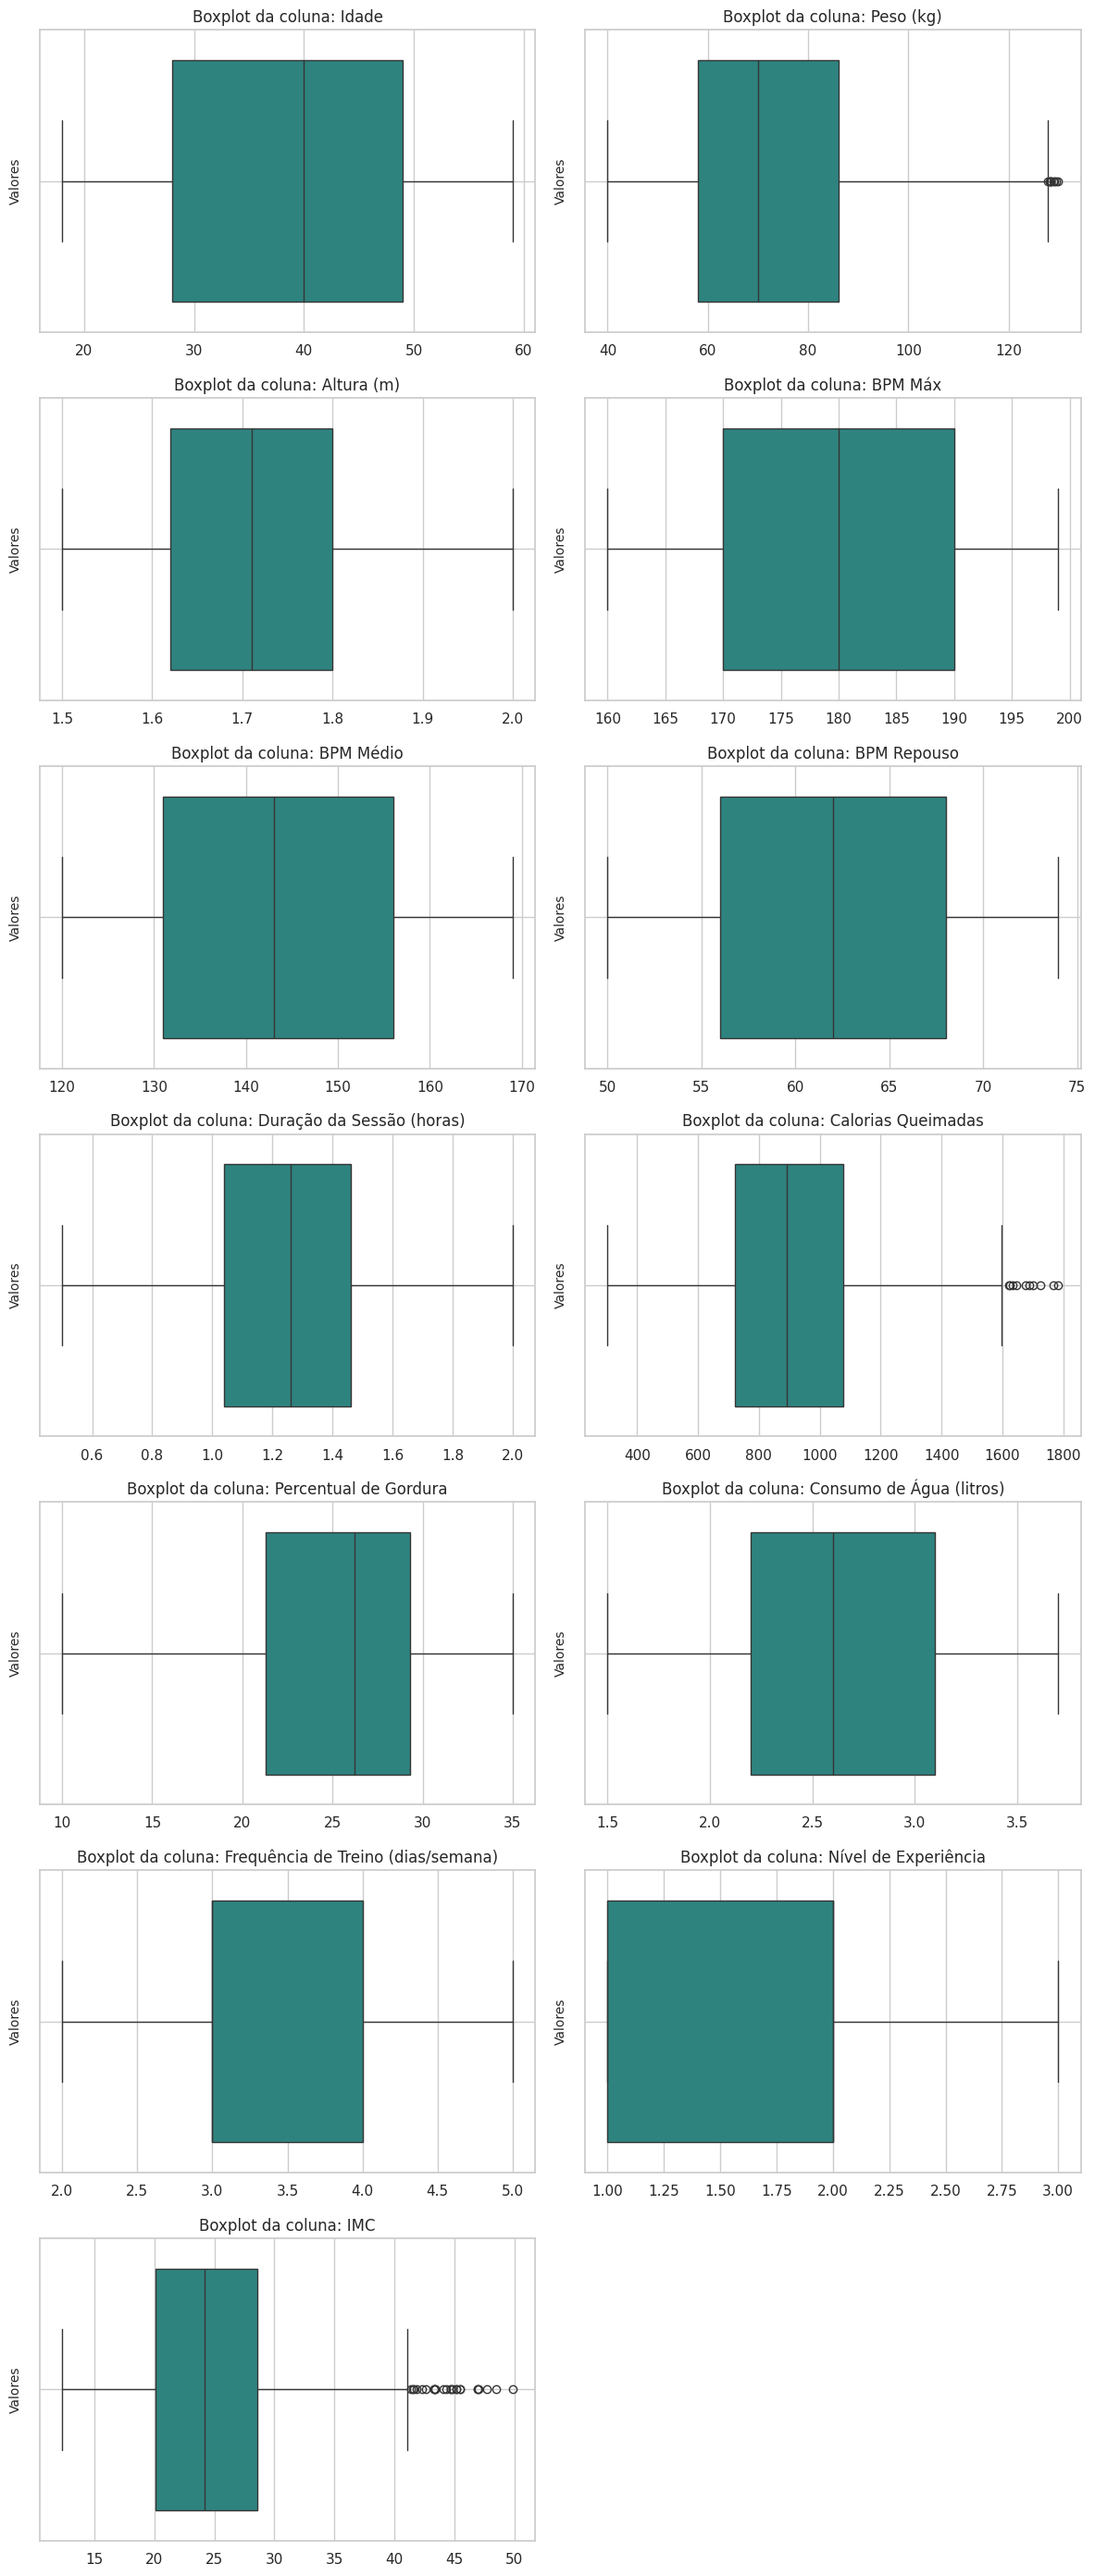

In [48]:
# Chamada da função para plotar os boxplots
boxplots(df_numerico, 2, (12,4))

Após exploração dos atributos por meio da visualização das distribuições em boxplots, verificou-se a presença de outliers em três deles: Peso (kg), Calorias Queimadas (atributo alvo) e IMC.
Como esses dados são necessários para a modelagem do problema, não serão descartados. Desse modo, será necessária a implementação de modelos mais robustos de forma que os outliers não influenciem significamente nos resultados.

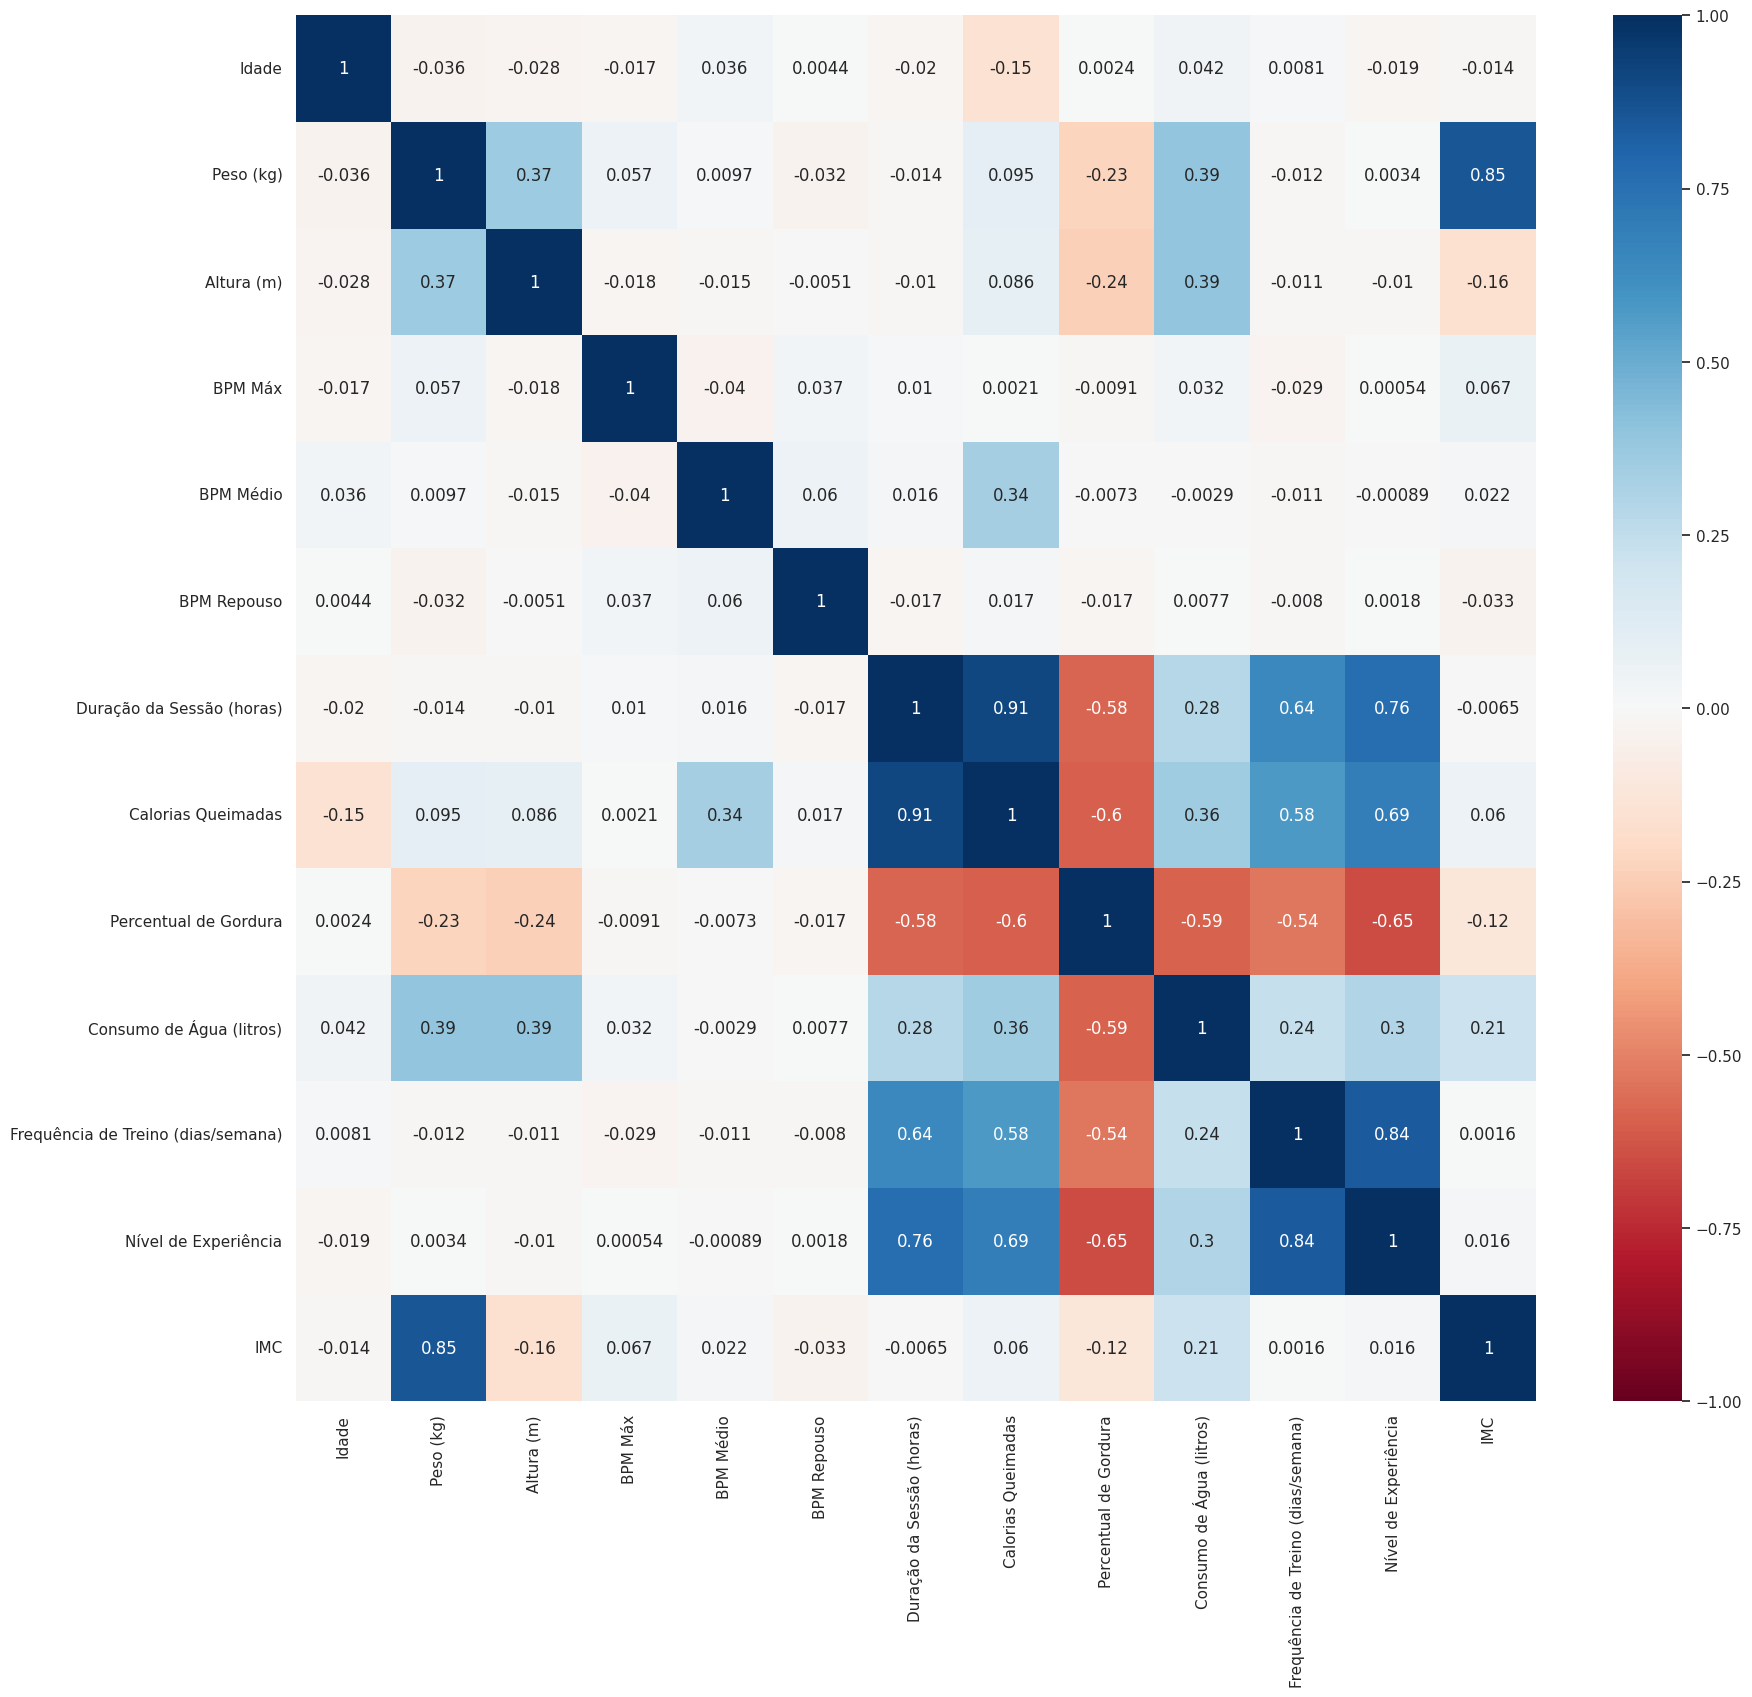

In [49]:
# Gerando a matriz de correlação de Pearson
plt.figure(figsize = (20,18))
sns.heatmap(df_numerico.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);

## Construção do Modelo de Machine Learning

### Separação dos dados, pré-processamento e divisão dos conjuntos de treino e teste

Os dados são divididos em bases de treino e teste. Foi escolhida uma divisão da base de dados em 80% para treino e 20% para teste.
O atributo categórico "Gênero" foi considerado nesse processo de divisão. A mesma é realizada de forma que as classes "Male" e "Female" estejam distrubuídas uniformemente entre as bases de treino e teste, reduzindo o risco de viés causado por desequilíbrio entre as bases.

In [51]:
# Divisão das matrizes
X = dataframe.drop(columns=['Calorias Queimadas'])  # Atributos de predição
y = dataframe['Calorias Queimadas']                 # Atributo alvo

# Garantir a presença do atributo "Gênero"
if 'Gênero' not in X.columns:
    raise ValueError("O atributo 'Gênero' deve estar"
                     "presente no conjunto de dados."
                    )

# Dividir em treino e teste com estratificação no atributo "Gênero"
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=X['Gênero']
                                                    )

# Verificar a distribuição do atributo "Gênero" em treino e teste
print("Distribuição em X_train:")
print(X_train['Gênero'].value_counts(normalize=True))

print("\nDistribuição em X_test:")
print(X_test['Gênero'].value_counts(normalize=True))

Distribuição em X_train:
Gênero
Male      0.525707
Female    0.474293
Name: proportion, dtype: float64

Distribuição em X_test:
Gênero
Male      0.523077
Female    0.476923
Name: proportion, dtype: float64


Após esse processo, é aplicado o One Hot Encoder para transformar as classes dos atributos categóricos em valores numéricos, de modo a ser possível aplicar os modelos de machine learning com esses dados, já que os algoritmos só podem ser executados com dados númericos.

In [52]:
# Configurar o OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# handle_unknown='ignore' garante que categorias desconhecidas no teste serão ignoradas.

# Ajustar o encoder na base de treino
one_hot_encoder.fit(X_train[['Gênero', 'Tipo de Treino']])

# Aplicar o encoder em ambas as bases
X_train_encoded = one_hot_encoder.transform(X_train[['Gênero', 'Tipo de Treino']])
X_test_encoded = one_hot_encoder.transform(X_test[['Gênero', 'Tipo de Treino']])

# Converter os resultados em DataFrames
nomes_colunas = one_hot_encoder.get_feature_names_out(['Gênero', 'Tipo de Treino'])
X_train_encoded = pd.DataFrame(X_train_encoded, columns=nomes_colunas, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=nomes_colunas, index=X_test.index)

# Concatenar com as demais colunas (excluindo as categóricas originais)
X_train_final = pd.concat([X_train.drop(columns=['Gênero', 'Tipo de Treino']), X_train_encoded], axis=1)
X_test_final = pd.concat([X_test.drop(columns=['Gênero', 'Tipo de Treino']), X_test_encoded], axis=1)

# Exibir as 5 primeiras linhas das bases
print("Base de treino (X_train):")
print(X_train_final.head())

print("\nBase de teste (X_test):")
print(X_test_final.head())

Base de treino (X_train):
     Idade  Peso (kg)  Altura (m)  BPM Máx  BPM Médio  BPM Repouso  \
22      50       71.0        1.68      187        161           70   
749     28       79.6        1.59      181        130           54   
551     30      113.4        1.91      177        137           54   
183     19       87.8        1.78      195        161           72   
277     50       51.5        1.71      199        155           64   

     Duração da Sessão (horas)  Percentual de Gordura  \
22                        1.17                   33.1   
749                       1.49                   28.2   
551                       1.27                   22.2   
183                       1.28                   23.6   
277                       1.48                   20.9   

     Consumo de Água (litros)  Frequência de Treino (dias/semana)  \
22                        2.5                                   2   
749                       1.5                                   3   
551

### Seleção dos atributos para construção dos modelos (Feature Selection)

Após a divisão das bases de treino e teste, além da transformação das classes dos atriutos categóricos, o conjunto de treino será aplicado em vários modelos de regressão. São comparados os resultados para cada modelo em três cenários: dados originais, dados transformados com normalização e dados transformados com padronização.
Antes do treinamento dos modelos, é realizada uma seleção dos melhores atributos para treinamento do modelo atrávés do algoritmo de feature selection. Nesse processo, foi escolhido o método da validação cruzada para o treinamento desses modelos com um número de k-folds igual a 10. O modelo escolhido para esse processo foi a Árvore de Regressão (Decision Tree Regressor) pois esse modelo possui bom desempenho com dados não transformados (normalizados ou padronizados). A escolha desse modelo para esse processo se justifica para otimizar o tempo de processamento de todo o projeto.

In [53]:
# Exemplo de uso da função
k_values = range(5, min(20, X_train.shape[1] + 1))  # Testar de 5 até o mínimo de 20 ou total de features

# Modelo selecionado
selected_model = DecisionTreeRegressor(random_state=42)

# Executar a seleção de features com o modelo escolhido
feature_selection_results, best_k, best_features = run_feature_selection_comparison(
    X_train_final, y_train, selected_model, k_values=k_values, cv=10
)


Modelo: DecisionTreeRegressor
k=5 -> MSE Médio: 15557.2073, Desvio: 7428.1645
Atributos Selecionados: Duração da Sessão (horas), Percentual de Gordura, Consumo de Água (litros), Frequência de Treino (dias/semana), Nível de Experiência
k=6 -> MSE Médio: 7372.6658, Desvio: 1022.6597
Atributos Selecionados: BPM Médio, Duração da Sessão (horas), Percentual de Gordura, Consumo de Água (litros), Frequência de Treino (dias/semana), Nível de Experiência
k=7 -> MSE Médio: 4820.5096, Desvio: 720.1245
Atributos Selecionados: Idade, BPM Médio, Duração da Sessão (horas), Percentual de Gordura, Consumo de Água (litros), Frequência de Treino (dias/semana), Nível de Experiência
k=8 -> MSE Médio: 4240.0851, Desvio: 940.6905
Atributos Selecionados: Idade, BPM Médio, Duração da Sessão (horas), Percentual de Gordura, Consumo de Água (litros), Frequência de Treino (dias/semana), Nível de Experiência, Gênero_Male
k=9 -> MSE Médio: 4281.2149, Desvio: 795.2428
Atributos Selecionados: Idade, BPM Médio, Duraçã

### Treinamento nos modelos

In [56]:
# Lista de modelos de regressão
models = {
    'Regressão Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Árvore de Decisão': DecisionTreeRegressor(random_state=42),
    'KNN Regressor': KNeighborsRegressor(),
    'SVR': SVR()
}

# Escalonadores
scalers = {
    'Atributos Originais': None,
    'Com Normalização': MinMaxScaler(),
    'Com Padronização': StandardScaler()
}

# Avaliar modelos utilizando as features selecionadas
results, all_cv_results_df = evaluate_models_on_training(
    X_train_final, y_train, models, scalers, best_features, cv=10
)

# Exibir resultados consolidados
print("\nResultados Consolidados:")
for scaler_name, scenario_results in results.items():
    print(f"\nCenário: {scaler_name}")
    for model_name, metrics in scenario_results.items():
        print(f"  Modelo: {model_name}")
        print(f"    MSE CV: {metrics['MSE CV']:.4f}")
        print(f"    Desvio: {metrics['MSE Desvio']:.4f}")
        print('-' * 30)


Cenário: Atributos Originais

Modelo: Regressão Linear
MSE CV: 1537.6799, Desvio: 392.9864

Modelo: Ridge
MSE CV: 1559.6325, Desvio: 388.8886

Modelo: Lasso
MSE CV: 1557.4356, Desvio: 383.5271

Modelo: ElasticNet
MSE CV: 23693.6400, Desvio: 2457.6886

Modelo: Random Forest
MSE CV: 1742.6809, Desvio: 422.4383

Modelo: Gradient Boosting
MSE CV: 447.4539, Desvio: 164.9037

Modelo: Árvore de Decisão
MSE CV: 4219.8347, Desvio: 735.3330

Modelo: KNN Regressor
MSE CV: 38595.7194, Desvio: 3572.5499

Modelo: SVR
MSE CV: 72006.5675, Desvio: 12713.1526

Cenário: Com Normalização

Modelo: Regressão Linear
MSE CV: 1538.2012, Desvio: 393.6505

Modelo: Ridge
MSE CV: 1640.1866, Desvio: 392.9264

Modelo: Lasso
MSE CV: 1574.8403, Desvio: 426.7615

Modelo: ElasticNet
MSE CV: 44377.7884, Desvio: 7482.7073

Modelo: Random Forest
MSE CV: 1733.1314, Desvio: 422.5284

Modelo: Gradient Boosting
MSE CV: 448.9534, Desvio: 164.3618

Modelo: Árvore de Decisão
MSE CV: 4199.6701, Desvio: 664.6354

Modelo: KNN Regre

TypeError: string indices must be integers

# Pensar em como construir o resultado gráfico para os treinamentos

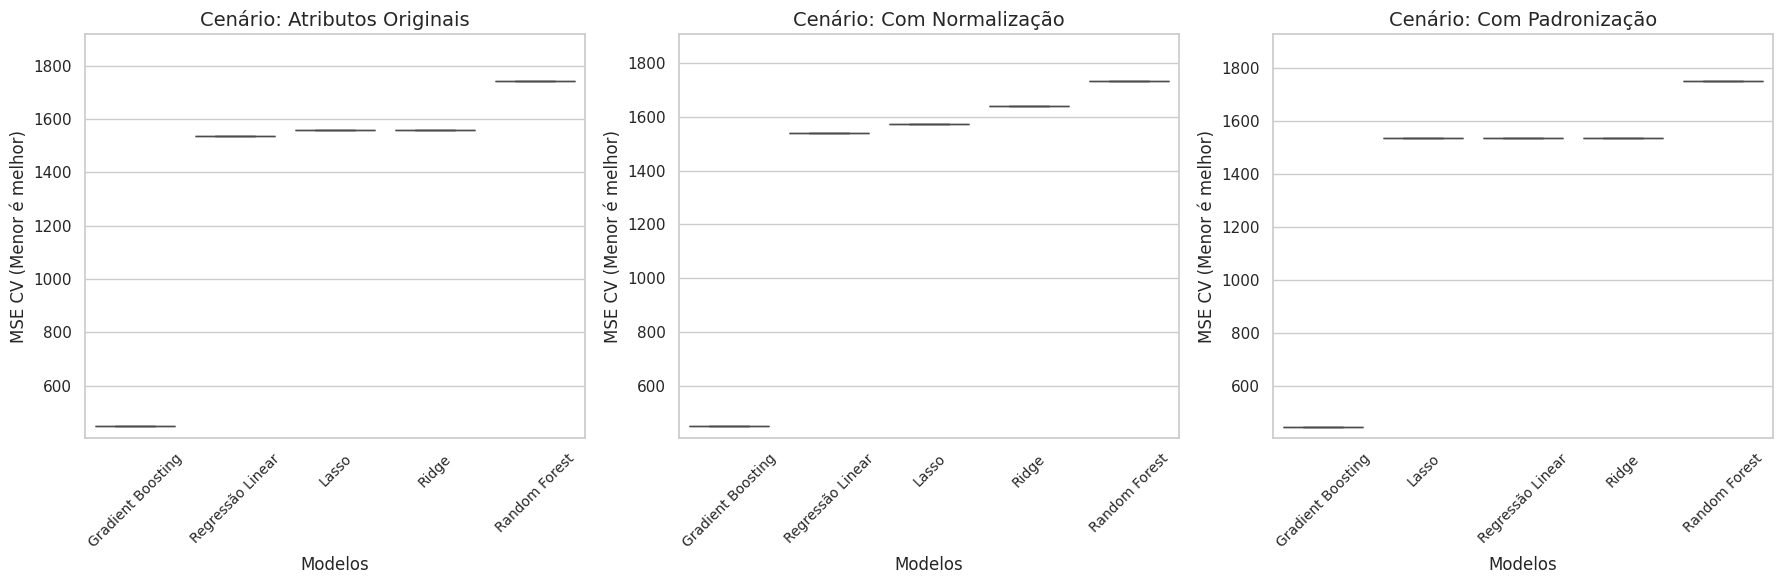

In [30]:
# Consolidar os resultados em um DataFrame
results_list = []
for scaler_name, scenario_results in results.items():
    for model_name, metrics in scenario_results.items():
        results_list.append({
            'Cenário': scaler_name,
            'Modelo': model_name,
            'MSE CV': metrics['MSE CV']
        })

results_df = pd.DataFrame(results_list)

# Criar gráficos individuais para cada cenário
unique_scenarios = results_df['Cenário'].unique()

# Configurar tamanho e layout
fig, axes = plt.subplots(1, len(unique_scenarios), figsize=(18, 6), sharey=False)

# Iterar sobre cada cenário e criar o gráfico correspondente
for ax, scenario in zip(axes, unique_scenarios):
    # Filtrar dados do cenário atual e selecionar os 5 melhores
    scenario_data = results_df[results_df['Cenário'] == scenario]
    top_5_models = scenario_data.nsmallest(5, 'MSE CV')

    # Calcular limites dinâmicos para o eixo Y
    y_min = top_5_models['MSE CV'].min() * 0.9  # Margem de 10% abaixo
    y_max = top_5_models['MSE CV'].max() * 1.1  # Margem de 10% acima

    # Criar o boxplot
    sns.boxplot(
        data=top_5_models,
        x='Modelo',
        y='MSE CV',
        ax=ax
    )
    ax.set_title(f"Cenário: {scenario}", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)
    ax.set_xlabel("Modelos", fontsize=12)
    ax.set_ylabel("MSE CV (Menor é melhor)", fontsize=12)
    ax.set_ylim(y_min, y_max)  # Aplicar limites dinâmicos ao eixo Y

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()

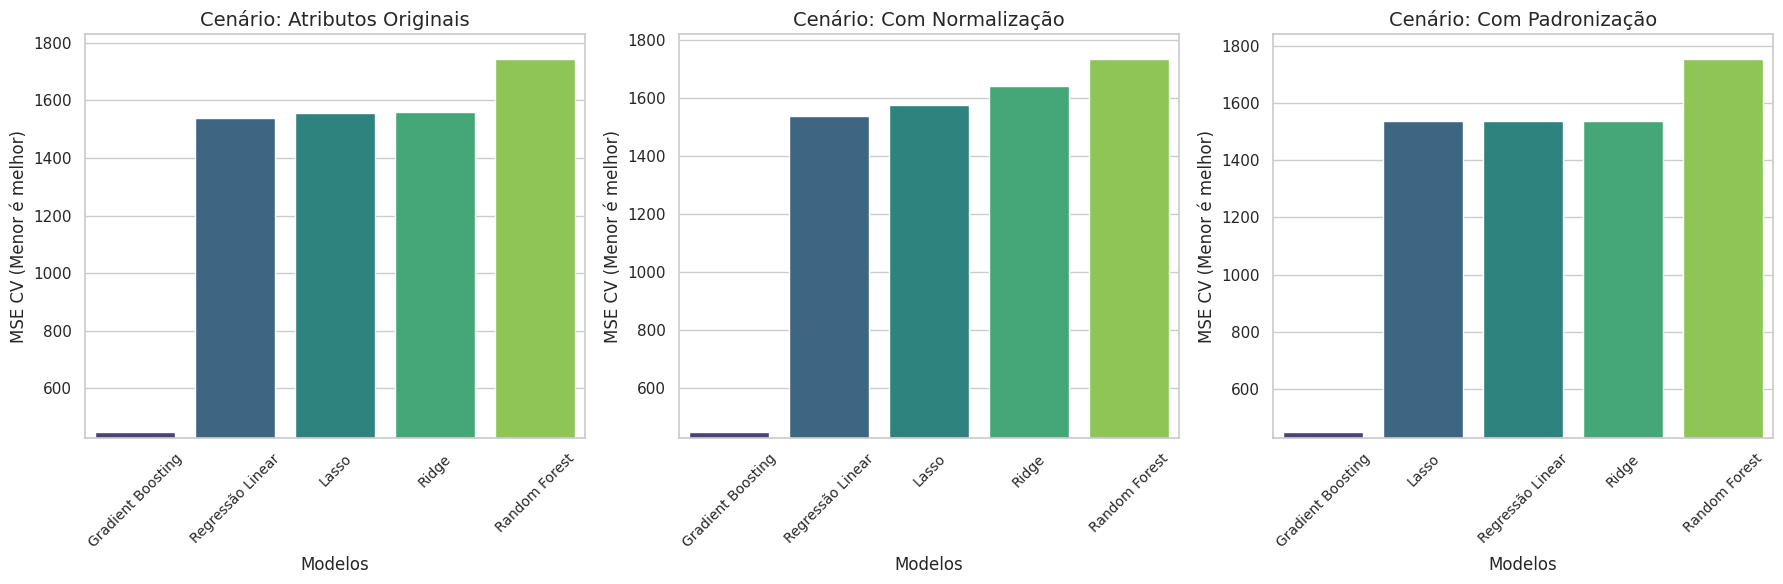

In [31]:
# Dados fornecidos organizados em DataFrame
data = {
    'Cenário': ['Atributos Originais'] * 9 + ['Com Normalização'] * 9 + ['Com Padronização'] * 9,
    'Modelo': [
        'Regressão Linear', 'Ridge', 'Lasso', 'ElasticNet', 'Random Forest', 'Gradient Boosting',
        'Árvore de Decisão', 'KNN Regressor', 'SVR'
    ] * 3,
    'MSE CV': [
        1537.6799, 1559.6325, 1557.4356, 23693.6400, 1742.6809, 447.4539, 4219.8347, 38595.7194, 72006.5675,
        1538.2012, 1640.1866, 1574.8403, 44377.7884, 1733.1314, 448.9534, 4199.6701, 10452.9036, 59770.2538,
        1537.6799, 1537.9778, 1536.0432, 9029.9192, 1753.2888, 448.4939, 4218.2122, 8272.3953, 58173.7776
    ],
    'Desvio': [
        392.9864, 388.8886, 383.5271, 2457.6886, 422.4383, 164.9037, 735.3330, 3572.5499, 12713.1526,
        393.6505, 392.9264, 426.7615, 7482.7073, 422.5284, 164.3618, 664.6354, 1102.8633, 10486.3522,
        392.9864, 392.2165, 395.4875, 1404.9485, 414.0016, 164.3013, 738.6085, 871.2588, 10366.1176
    ]
}

# Criar DataFrame
results_df = pd.DataFrame(data)

# Criar gráficos separados para cada cenário
unique_scenarios = results_df['Cenário'].unique()

# Configurar o layout para os gráficos
fig, axes = plt.subplots(1, len(unique_scenarios), figsize=(18, 6), sharey=False)

# Iterar pelos cenários e criar os gráficos
for ax, scenario in zip(axes, unique_scenarios):
    # Filtrar os 5 melhores modelos em termos de MSE CV
    scenario_data = results_df[results_df['Cenário'] == scenario]
    top_5_models = scenario_data.nsmallest(5, 'MSE CV')

    # Ajustar os limites do eixo Y
    y_min = top_5_models['MSE CV'].min() - 0.05 * top_5_models['MSE CV'].min()
    y_max = top_5_models['MSE CV'].max() + 0.05 * top_5_models['MSE CV'].max()

    # Criar o boxplot
    sns.barplot(
        data=top_5_models,
        x='Modelo',
        y='MSE CV',
        ax=ax,
        palette='viridis'
    )
    ax.set_title(f"Cenário: {scenario}", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)
    ax.set_xlabel("Modelos", fontsize=12)
    ax.set_ylabel("MSE CV (Menor é melhor)", fontsize=12)
    ax.set_ylim(y_min, y_max)  # Ajustar os limites do eixo Y

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()


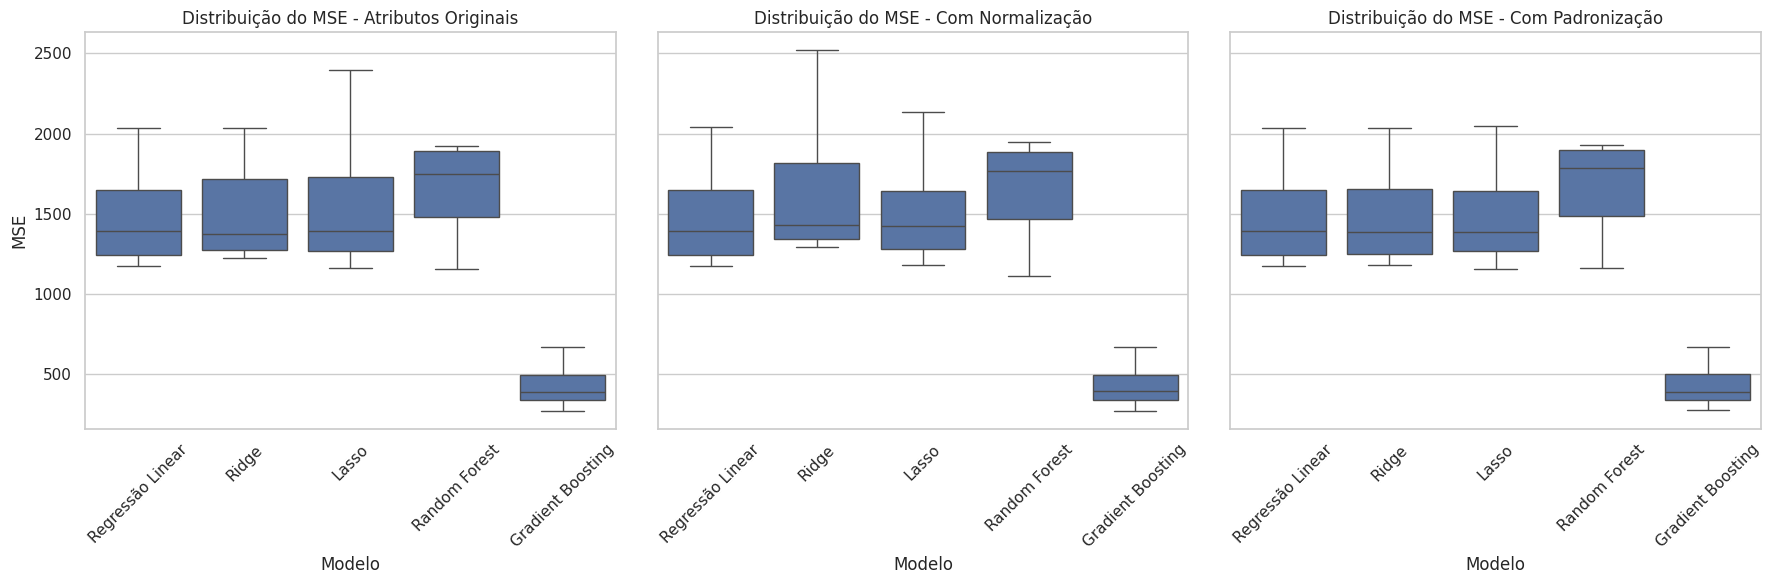

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar uma figura com três subgráficos (um para cada cenário)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Cenários: Atributos Originais, Com Normalização e Com Padronização
cenarios = ['Atributos Originais', 'Com Normalização', 'Com Padronização']

# Para cada cenário, plotar um boxplot separado
for i, cenario in enumerate(cenarios):
    ax = axes[i]

    # Filtrar os dados para o cenário atual
    cenario_data = all_cv_results_df[all_cv_results_df['Cenário'] == cenario]

    # Ordenar os modelos por MSE e pegar os 5 melhores (menores MSE)
    top_5_models = cenario_data.groupby('Modelo')['MSE'].mean().nsmallest(5).index
    top_5_data = cenario_data[cenario_data['Modelo'].isin(top_5_models)]

    # Plotar o boxplot para os 5 melhores modelos do cenário
    sns.boxplot(
        data=top_5_data,
        x='Modelo', y='MSE', ax=ax,
        showfliers=False
    )

    ax.set_title(f'Distribuição do MSE - {cenario}')
    ax.set_xlabel('Modelo')
    ax.set_ylabel('MSE')
    ax.tick_params(axis='x', rotation=45)  # Rotacionar rótulos do eixo x

# Ajustar o layout para evitar sobreposição de texto
plt.tight_layout()
plt.show()

### Aplicação do modelo na base de treino

In [ ]:
# Definir transformações para colunas numéricas e categóricas

atributos_num = ['Idade',
                    'Peso (kg)',
                    'Altura (m)',
                    'BPM Máx',
                    'BPM Médio',
                    'BPM Repouso',
                    'Duração da Sessão (horas)',
                    'Percentual de Gordura',
                    'Consumo de Água (litros)',
                    'Frequência de Treino (dias/semana)',
                    'Nível de Experiência',
                    'IMC'
                    ]

atributos_cat = ['Gênero', 'Tipo de Treino']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Combinar transformações com ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, atributos_num),
        ('cat', categorical_transformer, atributos_cat)
    ])

# Construir o pipeline completo

pipeline = Pipeline(steps=[ ('preprocessor', preprocessor),
                            ('feature_selection',
                             SelectKBest(score_func=f_regression, k=5)),
                            ('classifier',
                             RandomForestRegressor(n_estimators=200,
                                                   random_state=42)) ]
                    )

# Avaliar pipeline
scores = cross_val_score(pipeline, X_train, y_train,
                         cv=10, scoring='neg_mean_squared_error')

print(f'Mean cross-validation MSE: {-scores.mean():.2f}')

Mean cross-validation MSE: 6456.12


In [ ]:
# Definir parâmetros para grid search
param_grid = {
    'feature_selection__k': [5, 10, 15], # Seleção de top-K características
    'classifier': [RandomForestRegressor(random_state=42),
                   GradientBoostingRegressor(random_state=42)], # Changed 'ensemble' to 'classifier'
    'classifier__n_estimators': [100, 200, 300],   # Número de árvores  # Changed 'ensemble__' to 'classifier__'
    'classifier__max_depth': [3, 5, 10, 15, 25]  # Profundidade da árvore # Changed 'ensemble__' to 'classifier__'
}

In [ ]:
# Usar validação cruzada para encontrar o melhor conjunto de hiperparâmetros
grid_search = GridSearchCV(pipeline,
                           param_grid,
                           cv=5,
                           scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

ValueError: Invalid parameter 'classifier' for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Idade', 'Peso (kg)',
                                                   'Altura (m)', 'BPM Máx',
                                                   'BPM Médio', 'BPM Repouso',
                                                   'Duração da Sessão (horas)',
                                                   'Percentual de Gordura',
                                                   'Consumo de Água (litros)',
                                                   'Frequência de Treino '
                                                   '(dias/semana)',
                                                   'Nível de Experiência',
                                                   'IMC']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gênero',
                                                   'Tipo de Treino'])])),
                ('scaler', StandardScaler()), ('model', SVR())]). Valid parameters are: ['memory', 'steps', 'verbose'].

### Aplicação do modelo na base de teste

In [ ]:
# Avaliar desempenho no conjunto de teste
y_pred = grid_search.best_estimator_.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Resultados
print("Melhor configuração do modelo:", grid_search.best_params_)
print("MAE no conjunto de teste:", mae)
print("MSE no conjunto de teste:", mse)
print("R² no conjunto de teste:", r2)

Melhor configuração do modelo: {'classifier': GradientBoostingRegressor(random_state=42), 'classifier__max_depth': 3, 'classifier__n_estimators': 400, 'feature_selection__k': 10}
MAE no conjunto de teste: 12.02761082345446
MSE no conjunto de teste: 306.06800170173506
R² no conjunto de teste: 0.9963312207655922


## Considerações finais